In [51]:
from cnv_simulation import CNVsimulator_simpleWF, CNVsimulator_simpleChemo
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.optimize
import seaborn as sns

In [11]:
# get presimulated data aka sims used to approx posterior
theta_presimulated = np.genfromtxt('presimulated_data/WF_presimulated_theta_100000_1.csv',delimiter=',')
x_presimulated = np.genfromtxt('presimulated_data/WF_presimulated_data_100000_1.csv',delimiter=',')

In [9]:
# get data WF
wf_obs = np.genfromtxt("WF_simulated_single_observations_new.csv",delimiter=',')
# get a single observation and the corresponding params
observation = wf_obs[0,0:25]
true_params = wf_obs[0,25:27]

In [36]:
def distance_euc(sim, obs):
    d=((sim-obs)**2).sum(axis=1)
    return d**0.5

def distance_mae(sim, obs):
    d = sim - obs
    absd = np.abs(d)
    return absd.sum(axis=1) 

In [38]:
distances_e = distance_euc(x_presimulated, observation)
distances_m = distance_mae(x_presimulated, observation)

In [39]:
# threshold that accepts 5% of the samples
quantile = 0.05
ϵ_e = np.quantile(distances_e, quantile)
ϵ_m = np.quantile(distances_m, quantile)
# get accepted
idx_accepted_e = distances_e < ϵ_e
idx_accepted_m = distances_m < ϵ_m

In [44]:
# get accepted params
posterior_e = theta_presimulated[idx_accepted_e, ]
posterior_m = theta_presimulated[idx_accepted_m, ]

In [46]:
def kernelminus(x):
    return -kernel(x)

In [56]:
fitness_samples = np.asarray(posterior_m[:,0])
mut_samples = np.asarray(posterior_m[:,1])
    
#calculations kde
ymin = fitness_samples.min()
ymax = fitness_samples.max()
xmin = mut_samples.min()
xmax = mut_samples.max()
    
s_range, μ_range = np.mgrid[ymin:ymax:100j, xmin:xmax:100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([fitness_samples, mut_samples])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)

    
#estimates for parameters from the posterior (MAP - highest probability in posterior)
idx = np.argmax(density, axis=None)
param_guess = np.array([positions[0,idx],positions[1,idx]])
s_est, μ_est = scipy.optimize.minimize(kernelminus,param_guess, method ='Nelder-Mead', options={'disp': True}).x
map_log_prob = np.log(kernel([s_est, μ_est]))

Optimization terminated successfully.
         Current function value: -0.668560
         Iterations: 33
         Function evaluations: 63


/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


NameError: name 'CS2' is not defined

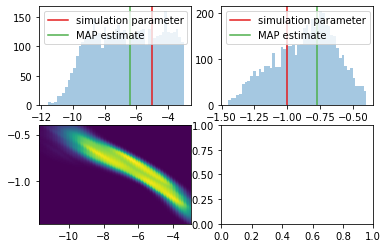

In [57]:
    red, blue, green = sns.color_palette('Set1', 3)
    fig, axes = plt.subplots(2, 2)
    # marginal
    sns.distplot(fitness_samples, bins=50, kde=False, ax=axes[0,1])
    sns.distplot(mut_samples, bins=50, kde=False, ax=axes[0,0]) 
    #marginal 95% hdis
    #axes[2,1].axvline(fit_95hdi_low, color='k', linestyle=':')
    #axes[2,1].axvline(fit_95hdi_high, color='k', linestyle=':',label="95% HDI")
    #axes[1,0].axvline(mut_95hdi_low, color='k', linestyle=':')
    #axes[1,0].axvline(mut_95hdi_high, color='k', label="95% HDI", linestyle=':')
    # MAP and true params
    axes[0,1].axvline(true_params[0], color=red, label="simulation parameter")
    axes[0,1].axvline(s_est, color=green, label="MAP estimate")
    axes[0,0].axvline(true_params[1], color=red, label="simulation parameter")
    axes[0,0].axvline(μ_est, color=green, label="MAP estimate")
    axes[0,1].set(xlabel='log10(CNV fitness effect)')
    axes[0,0].set(xlabel='log10(CNV mutation rate)')
    axes[0,1].legend(loc='upper left')
    axes[0,0].legend(loc='upper left')
    
    # joint
#     axes[2,0].set_xlim(μ_range.min(),μ_range.max())
#     axes[2,0].set_ylim(s_range.min(),s_range.max())
    # #get values from contour
    axes[1,0].pcolormesh(μ_range, s_range, density)
    #CS2=axes[1,0].contour(μ_range, s_range,get_hdr(density, mylevel=[0.95]), colors='white')
    #CS3=axes[1,0].contour(μ_range, s_range,get_hdr(density, mylevel=[0.5]), colors='lightgrey')
    axes[1,0].clabel(CS2, fmt='0.95')
    axes[1,0].clabel(CS3, fmt='0.5')
    axes[1,0].plot(true_params[1],true_params[0], color=red, marker='o', label="simulation parameter")
    axes[1,0].plot(μ_est, s_est, color="k", marker='o', label="MAP estimate")
    axes[1,0].legend(loc='lower left', prop={'size': 12})
    axes[1,0].set(xlabel='log10(CNV mutation rate)', ylabel='log10(CNV fitness effect)')